In [1]:
from layout_utils.layout import Layout
from pulp import *
import numpy as np
import random
from math import ceil
from copy import deepcopy
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt 
import networkx as nx
import pickle
import os
from solver.slap_models import SLAP, SLAP_PA, SLAP_QA
import solver.ga as ga
from layout_utils.graph_tools import viz_graph

ModuleNotFoundError: No module named 'layout_utils'

In [ ]:
def render_warehouse(warehouse: Layout, assignment, product_frequency):
    storage_assignment = deepcopy(warehouse.layout_grid)
    walkable_locs = np.where(warehouse.layout_grid == 0)

    for x, y, z in zip(walkable_locs[0], walkable_locs[1], walkable_locs[2]):
        storage_assignment[x,y,z] = -100

    for i, loc in enumerate(assignment):
        storage_assignment[warehouse.nodes_list[loc]] = i 

    storage_frequence = deepcopy(warehouse.layout_grid)
    for i, loc in enumerate(assignment):
        storage_frequence[warehouse.nodes_list[loc]] = product_frequency[i]
    
    node_xyz = np.array([warehouse.pos_dict[v] for v in sorted(warehouse.graph)])
    edge_xyz = np.array([(warehouse.pos_dict[u], warehouse.pos_dict[v]) for u, v in warehouse.graph.edges()])

    data = []
    for x, y, z in zip(node_xyz.T[0], node_xyz.T[1], node_xyz.T[2]):
        data_point = storage_frequence[x,y,z]
        data.append(data_point)

    assignment_plt = []
    for x, y, z in zip(node_xyz.T[0], node_xyz.T[1], node_xyz.T[2]):
        assignment_point = storage_assignment[x,y,z]
        assignment_plt.append(assignment_point)

    trace = go.Scatter3d(customdata=np.stack((data,assignment_plt),axis=-1), hovertemplate = 'x: %{x}<br>y: %{y}<br>z: %{z}<br>Order Frequency: %{customdata[0]}<br>Product: %{customdata[1]}}',
        x = node_xyz.T[0], y = node_xyz.T[1], z = node_xyz.T[2],mode = 'markers', marker = dict(symbol="square",
            size = 12,
            color = data, # set color to an array/list of desired values
            colorscale = 'thermal')
        )
    layout = go.Layout(title = 'Warehouse Visualization')
    fig = go.Figure(data = [trace], layout = layout)
    fig.update_traces(marker_size = 5)
    return fig

In [ ]:
custom_grid = np.ones((7, 12, 1)) * -1
custom_grid[:,0,0] = -1
custom_grid[:,1,0] = 0
custom_grid[:,2,0] = -1
custom_grid[:,3,0] = -1

custom_grid[:,4,0] = 0
custom_grid[:,5,0] = -1
custom_grid[:,6,0] = -1

custom_grid[:,7,0] = 0
custom_grid[:,8,0] = -1
custom_grid[:,9,0] = -1

custom_grid[:,10,0] = 0
custom_grid[:,11,0] = -1
custom_grid[:,11,0] = -1
custom_grid[0,:] = 0
custom_grid[-1,:] = 0



In [ ]:
custom_grid[:,:,0]

In [ ]:
double_deep = True
warehouse = Layout(7, 13, 1, True, True, custom_grid)
path = os.path.join("data", "dist_mat_" + str(warehouse.layout_grid.shape) + "_" + str(double_deep) + ".npy")

dist_mat = warehouse.gen_dist_mat(path)

In [ ]:
warehouse_heatmap = px.imshow(warehouse.layout_grid[:,:,0])
warehouse_heatmap

In [12]:
warehouse_heatmap.write_json("render/warehouse_heatmap.json")

FileNotFoundError: [Errno 2] No such file or directory: 'render\\warehouse_heatmap.json'

In [13]:
size = len(warehouse.storage_locs)
product_pairs_frequency = np.zeros((size, size))
upper_bound = 9
for i in range(size):
    for j in range(size):
        if i == j: 
            product_pairs_frequency[i][j] = 0
        # since problem is a one-one problem, mapping (1,2) == (2,1) so there's no need to create duplicate mappings
        #if (j,i) in product_pairs_frequency: continue
        else:
            product_pairs_frequency[i][j] = random.randrange(0, upper_bound)

In [14]:
product_frequency = {}
for i in range(size):
    product_frequency[i] = product_pairs_frequency[i].sum()

In [15]:
n_storage_locs = len(warehouse.storage_locs)
#n_products = len(warehouse.storage_locs)
n_products = len(product_frequency.keys())

storage_locs = [warehouse.nodes_list.index(loc) for loc in warehouse.storage_locs]
products = [p for p in range(n_products)]
storage_loc_mapping = {i:loc for i,loc in enumerate(storage_locs)}
storage_locs_new = [i for i in storage_loc_mapping.keys()]
depot = 0

In [16]:
assignment = storage_locs

In [17]:
product_frequency

{0: 152.0,
 1: 167.0,
 2: 130.0,
 3: 141.0,
 4: 136.0,
 5: 158.0,
 6: 153.0,
 7: 189.0,
 8: 159.0,
 9: 158.0,
 10: 165.0,
 11: 187.0,
 12: 157.0,
 13: 143.0,
 14: 148.0,
 15: 156.0,
 16: 173.0,
 17: 168.0,
 18: 137.0,
 19: 148.0,
 20: 151.0,
 21: 165.0,
 22: 139.0,
 23: 165.0,
 24: 188.0,
 25: 164.0,
 26: 143.0,
 27: 164.0,
 28: 197.0,
 29: 170.0,
 30: 171.0,
 31: 161.0,
 32: 165.0,
 33: 166.0,
 34: 148.0,
 35: 152.0,
 36: 142.0,
 37: 154.0,
 38: 135.0,
 39: 174.0}

In [18]:
fig = render_warehouse(warehouse, assignment, product_frequency)

In [19]:
fig.show()

In [20]:
fig.write_json("render/warehouse_3d.json")

FileNotFoundError: [Errno 2] No such file or directory: 'render\\warehouse_3d.json'

Text(0.5, 0, 'z-axis')

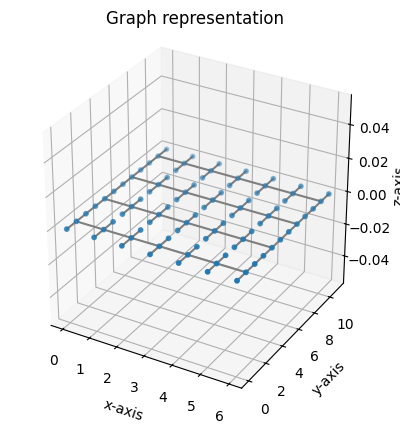

In [21]:
node_xyz = np.array([warehouse.pos_dict[v] for v in sorted(warehouse.graph)])
edge_xyz = np.array([(warehouse.pos_dict[u], warehouse.pos_dict[v]) for u, v in warehouse.graph.edges()])
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

#plot nodes
ax.scatter(node_xyz.T[0], node_xyz.T[1], node_xyz.T[2], s=10)

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

ax.set_box_aspect([1,1,1])
ax.set_title("Graph representation")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')

In [22]:
dist_mat_storage = dist_mat[storage_locs][:, storage_locs]

NameError: name 'dist_mat' is not defined

In [23]:
products = [0, 1, 2, 3]
storage_locs = [0, 1, 2, 3]
w = np.array([[0,3,0,2], 
     [3,0,0,1], #Flow matrix (between assignees)
     [0,0,0,4],
     [2,1,4,0]])

d = np.array([[0,22,53,53],
     [22,0,40,62], #Distance matrix (between assignments)
     [53,40,0,55],
     [53,62,55,0]])

slap = SLAP_QA(d, products, w, storage_locs, depot)

In [24]:
slap.report()

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 PRO 7840U w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 8 rows, 16 columns and 32 nonzeros
Model fingerprint: 0x93cffeac
Model has 48 quadratic objective terms
Variable types: 0 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1022.0000000
Presolve time: 0.00s
Presolved: 56 rows, 64 columns, 176 nonzeros
Variable types: 0 continuous, 64 integer (64 binary)

Root relaxation: objective 0.000000e+00, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |   

In [25]:
slap = SLAP(dist_mat, products, product_frequency, storage_locs, depot)

NameError: name 'dist_mat' is not defined

In [ ]:
slap.report() 

In [ ]:
slap = SLAP_PA(dist_mat, products, product_frequency, product_pairs_frequency, storage_locs, depot)

In [ ]:
slap.report()

In [ ]:
fig_new = render_warehouse(warehouse, [11, 12, 6, 9, 8, 5], product_frequency)

In [ ]:
fig_new.show()

In [ ]:
#fig_new.write_json("new_layout.json") 

In [ ]:
def generate_genome(products, locations_list):
    chromosome = []
   
    random.shuffle(locations_list)
    for i in range(len(products)):
        storage_loc = locations_list[i]
        chromosome.append(storage_loc)
    return chromosome

In [ ]:
initial_population = [generate_genome(products, storage_locs) for _ in range(200)]

In [ ]:
fitness_tracker = []
min_fitness = np.inf
for g in range(5000):
    new_pop = []
    pop_results = []
    
   
    fitness_result = [ga.fitness_qa(pop, d, w) for pop in initial_population]
    print(g, min(fitness_result))
    fitness_tracker.append(min(fitness_result))
    for _ in range(100):
        selected = ga.selection(initial_population, fitness_result)
        child = ga.crossover(selected)
        mutated = ga.mutation(child)
        new_pop.append(mutated)
    initial_population = new_pop

min_fitness = min(fitness_result)
min_child = initial_population[fitness_result.index(min_fitness)]

In [ ]:
# initial_population = [ga.generate_genome(products, warehouse) for i in range(1000)]

    
#product_pairs_frequency = calc_product_affinity(orders)
# product_frequency_pf_pa = [0 for i in range(len(product_frequency.keys()))]
# for i in list(product_frequency.values()):
product_frequency_pf_pa = list(product_frequency.values())



# product_pairs_np = np.zeros((n_products, n_products))
# for key in product_pairs_frequency.keys():
#     for pair in product_pairs_frequency[key].keys():
#         product_pairs_np[key][pair] = product_pairs_frequency[key][pair]

fitness_tracker = []
min_fitness = np.inf
for g in range(500):
    new_pop = []
    pop_results = []
    
   
    fitness_result = [ga.fitness_pf_pa(pop, dist_mat, product_frequency_pf_pa, product_pairs_frequency) for pop in initial_population]
    print(g, min(fitness_result))
    fitness_tracker.append(min(fitness_result))
    for _ in range(100):
        selected = ga.selection(initial_population, fitness_result)
        child = ga.crossover(selected)
        mutated = ga.mutation(child)
        new_pop.append(mutated)
    initial_population = new_pop

min_fitness = min(fitness_result)
min_child = initial_population[fitness_result.index(min_fitness)]